In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical as make_class_categorical
import _pickle as pickle
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
def LoadBatch(filename):
    """
    Loads batch based on the given filename and produces the X, Y, and y arrays

    :param filename: Path of the file
    :return: X, Y and y arrays
    """

    # borrowed from https://www.cs.toronto.edu/~kriz/cifar.html
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    dictionary = unpickle(filename)

    # borrowed from https://stackoverflow.com/questions/16977385/extract-the-nth-key-in-a-python-dictionary?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
    def ix(dic, n):  # don't use dict as  a variable name
        try:
            return list(dic)[n]  # or sorted(dic)[n] if you want the keys to be sorted
        except IndexError:
            print('not enough keys')

    garbage = ix(dictionary, 1)
    y = dictionary[garbage]
    Y = np.transpose(make_class_categorical(y, 10))
    garbage = ix(dictionary, 2)
    X = np.transpose(dictionary[garbage]) / 255

    return X, Y, y

#### Weight initialization

In [3]:
def initialize_weights(shapes_list, std=0.001):
    """
    Initializes the weight and bias arrays for the 2 layers of the network

    :param shapes_list: List that contains the shapes of the weight matrices of each layer. The number of layers can be found through
                        estimating the length of this list.
    :param variance (optional): The variance of the normal distribution that will be used for the initialization of the weights

    :return: Weights and bias arrays for each layer of the network stored in lists
    """

#     np.random.seed(400)

    weights = []
    biases = []

    for shape in shapes_list:

        W = np.random.normal(0, std, size=(shape[0], shape[1]))
        b = np.zeros(shape=(shape[0], 1))

        weights.append(W)
        biases.append(b)

    return weights, biases

In [4]:
def he_initialization_k_layers(shapes_list):
    """
    He initialization on the weight matrices.

    :param shapes_list: List that contains the dimensions of each layer of the network.

    :return: Initialized weight and bias matrices based on He initialization of the weights.
    """

    weights = []
    biases = []

    for pair in shapes_list:

        weights.append(np.random.randn(pair[0], pair[1]) * np.sqrt(2 / float(pair[0])))
        biases.append(np.zeros(shape=(pair[0], 1)))

    return weights, biases


#### Activation function

In [5]:
def ReLU(x):
    """
    Rectified Linear Unit function

    :param x: Input to the function

    :return: Output of ReLU(x)
    """

    return np.maximum(x, 0)

#### Classifier Evaluation

In [6]:
def softmax(X, theta=1.0, axis=None):
    """
    Softmax over numpy rows and columns, taking care for overflow cases
    Many thanks to https://nolanbconaway.github.io/blog/2017/softmax-numpy
    Usage: Softmax over rows-> axis =0, softmax over columns ->axis =1

    :param X: ND-Array. Probably should be floats.
    :param theta: float parameter, used as a multiplier prior to exponentiation. Default = 1.0
    :param axis (optional): axis to compute values along. Default is the first non-singleton axis.

    :return: An array the same size as X. The result will sum to 1 along the specified axis
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis=axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis=axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

In [7]:
def EvaluateClassifier(X, weights, biases):
    """
    Computes the Softmax output of the k-layer network, based on input data X and trained weight and bias arrays

    :param X: Input data
    :param weights: Weights arrays of the k layers
    :param biases: Bias vectors of the k layers

    :return: Softmax output of the trained network, along with the intermediate layer outpouts and activations
    """

    intermediate_outputs = [] # s's
    intermediate_activations = [] #h's

    s = np.dot(weights[0], X) + biases[0]
    intermediate_outputs.append(s)
    h = ReLU(s)
    intermediate_activations.append(h)

    for i in range(1, len(weights) - 1):

        s = np.dot(weights[i], intermediate_activations[-1]) + biases[i]
        intermediate_outputs.append(s)
        h = ReLU(s)
        intermediate_activations.append(h)

    s = np.dot(weights[-1], intermediate_activations[-1]) + biases[-1]
    p = softmax(s, axis=0)

    return p, intermediate_activations, intermediate_outputs

#### Compute Accuracy

In [8]:
def predictClasses(p):
    """
    Predicts classes based on the softmax output of the network

    :param p: Softmax output of the network
    :return: Predicted classes
    """

    return np.argmax(p, axis=0)

In [9]:
def ComputeAccuracy(X, y, weights, biases):
    """
    Computes the accuracy of the feed-forward 2-layer network

    :param X: Input data
    :param weights: Weights arrays of the k layers
    :param biases: Bias vectors of the k layers

    :return: Accuracy performance of the neural network.
    """
    p, _, _ = EvaluateClassifier(X, weights, biases)
    predictions = predictClasses(p)

    accuracy = round(np.sum(np.where(predictions - y == 0, 1, 0)) * 100 / len(y), 2)

    return accuracy

#### Compute Cost 

In [10]:
def ComputeCost(X, Y, weights, biases, regularization_term=0):
    """
    Computes the cross-entropy loss on a batch of data.

    :param X: Input data
    :param y: Labels of the ground truth
    :param weights: Weights arrays of the k layers
    :param biases: Bias vectors of the k layers
    :param regularization_term: Amount of regularization applied.

    :return: Cross-entropy loss.
    """

    p, _, _ = EvaluateClassifier(X, weights, biases)

    cross_entropy_loss = -np.log(np.diag(np.dot(Y.T, p))).sum() / float(X.shape[1])

    weight_sum = 0
    for weight in weights:

        weight_sum += np.power(weight, 2).sum()

    return cross_entropy_loss + regularization_term * weight_sum

#### Compute Gradients

In [11]:
def ComputeGradsNumSlow(X, Y, weights, biases, start_index=0, h=1e-5):
    """
    Computes gradient descent updates on a batch of data with numerical computations of great precision, thus slower computations.
    Contributed by Josephine Sullivan for educational purposes for the DD2424 Deep Learning in Data Science course.

    :param X: Input data.
    :param Y: One-hot representation of the true labels of input data X.
    :param weights: Weights arrays of the k layers.
    :param biases: Bias vectors of the k layers.
    :param start_index: In case there are already some weights and bias precomputed, we need to compute the numerical gradients for 
                        those weights and bias that have other shapes (the 2 last layers in fact).

    :return: Weight and bias updates of the k layers of our network computed with numerical computations with high precision.
    """
    
    grad_weights = []
    grad_biases = []
    
    for layer_index in range(start_index, len(weights)):
        
        W = weights[layer_index]
        b = biases[layer_index]
        
        grad_W = np.zeros(W.shape)
        grad_b = np.zeros(b.shape)

        for i in tqdm(range(b.shape[0])):
            b_try = np.copy(b)
            b_try[i, 0] -= h
            temp_biases = biases.copy()
            temp_biases[layer_index] = b_try
            c1 = ComputeCost(X=X, Y=Y, weights=weights, biases=temp_biases)
            b_try = np.copy(b)
            b_try[i, 0] += h
            temp_biases = biases.copy()
            temp_biases[layer_index] = b_try
            c2 = ComputeCost(X=X, Y=Y, weights=weights, biases=temp_biases)

            grad_b[i, 0] = (c2 - c1) / (2 * h)

        grad_biases.append(grad_b)

        for i in tqdm(range(W.shape[0])):
            for j in range(W.shape[1]):
                W_try = np.copy(W)
                W_try[i, j] -= h
                temp_weights = weights.copy()
                temp_weights[layer_index] = W_try
                c1 = ComputeCost(X=X, Y=Y, weights=temp_weights, biases=biases)
                W_try = np.copy(W)
                W_try[i, j] += h
                temp_weights = weights.copy()
                temp_weights[layer_index] = W_try
                c2 = ComputeCost(X=X, Y=Y, weights=temp_weights, biases=biases)

                grad_W[i, j] = (c2 - c1) / (2 * h)

        grad_weights.append(grad_W)

    return grad_weights, grad_biases

In [12]:
def ComputeGradsNumSlowBatchNorm(X, Y, weights, biases, start_index=0, h=1e-5):
    """
    Computes gradient descent updates on a batch of data with numerical computations of great precision, thus slower computations.
    Contributed by Josephine Sullivan for educational purposes for the DD2424 Deep Learning in Data Science course.

    :param X: Input data.
    :param Y: One-hot representation of the true labels of input data X.
    :param weights: Weights arrays of the k layers.
    :param biases: Bias vectors of the k layers.
    :param start_index: In case there are already some weights and bias precomputed, we need to compute the numerical gradients for
                        those weights and bias that have other shapes (the 2 last layers in fact).

    :return: Weight and bias updates of the k layers of our network computed with numerical computations with high precision.
    """

    grad_weights = []
    grad_biases = []

    for layer_index in range(start_index, len(weights)):

        W = weights[layer_index]
        b = biases[layer_index]

        grad_W = np.zeros(W.shape)
        grad_b = np.zeros(b.shape)

        for i in tqdm(range(b.shape[0])):
            b_try = np.copy(b)
            b_try[i, 0] -= h
            temp_biases = biases.copy()
            temp_biases[layer_index] = b_try
            c1 = ComputeCostBatchNormalization(X=X, Y=Y, weights=weights, biases=temp_biases, regularization_term=0)
            b_try = np.copy(b)
            b_try[i, 0] += h
            temp_biases = biases.copy()
            temp_biases[layer_index] = b_try
            c2 = ComputeCostBatchNormalization(X=X, Y=Y, weights=weights, biases=temp_biases, regularization_term=0)

            grad_b[i, 0] = (c2 - c1) / (2 * h)

        grad_biases.append(grad_b)

        for i in tqdm(range(W.shape[0])):
            for j in range(W.shape[1]):
                W_try = np.copy(W)
                W_try[i, j] -= h
                temp_weights = weights.copy()
                temp_weights[layer_index] = W_try
                c1 = ComputeCostBatchNormalization(X=X, Y=Y, weights=temp_weights, biases=biases, regularization_term=0)
                W_try = np.copy(W)
                W_try[i, j] += h
                temp_weights = weights.copy()
                temp_weights[layer_index] = W_try
                c2 = ComputeCostBatchNormalization(X=X, Y=Y, weights=temp_weights, biases=biases, regularization_term=0)

                grad_W[i, j] = (c2 - c1) / (2 * h)

        grad_weights.append(grad_W)

    return grad_weights, grad_biases

In [13]:
def ComputeGradients(X, Y, weights, biases, p, outputs, activations, regularization_term=0):
    """
    Computes gradient descent updates on a batch of data

    :param X: Input data
    :param Y: One-hot representation of the true labels of input data X
    :param weights: Weight matrices of the k layers
    :param biases: Bias vectors of the k layers
    :param p: Softmax probabilities (predictions) of the network over classes.
    :param outputs: True outputs of the intermediate layers of the network.
    :param activations: ReLU activations of the intermediate layers of the network.
    :param regularization_term: Contribution of the regularization in the weight updates

    :return: Weight and bias updates of the first and second layer of our network
    """

    # Back-propagate output layer at first

    weight_updates = []
    bias_updates = []

    g = p - Y
    bias_updates.append(g.sum(axis=1).reshape(biases[-1].shape))
    weight_updates.append(np.dot(g, activations[-1].T))

    for i in reversed(range(len(weights) -1)):
    # Back-propagate the gradient vector g to the layer before

        g = np.dot(g.T, weights[i+1])
        ind = 1 * (outputs[i] > 0)
        g = g.T * ind

        if i == 0:
            weight_updates.append(np.dot(g, X.T))
        else:
            weight_updates.append(np.dot(g, activations[i-1].T))

        bias_updates.append(np.sum(g, axis=1).reshape(biases[i].shape))

    for elem in weight_updates:
        elem /= X.shape[1]

    for elem in bias_updates:
        elem /= X.shape[1]

    # Reverse the updates to match the order of the layers
    weight_updates = list(reversed(weight_updates)).copy()
    bias_updates = list(reversed(bias_updates)).copy()

    # Add regularizers
    for index in range(len(weight_updates)):
        weight_updates[index] += 2*regularization_term * weight_updates[index]

    return weight_updates, bias_updates

In [14]:
def check_similarity(grad_weights, grad_biases, num_weights, num_biases):
    """
    Compares the gradients of both the analytical and numerical method and prints out a message of result
    or failure, depending on how close these gradients are between each other.

    :param grad_weights: Analytically computed gradients of the weights
    :param grad_biases: Analytically computed gradients of the biases
    :param num_weights: Numerically computed gradients of the weights
    :param num_biases: Numerically computed gradients of the biases

    :return: None
    """

    for layer_index in range(len(grad_weights)):

        print('-----------------')
        print(f'Layer no. {layer_index+1}:')

        weight_abs = np.abs(grad_weights[layer_index] - num_weights[layer_index])
        bias_abs = np.abs(grad_biases[layer_index] - num_biases[layer_index])

        weight_nominator = np.average(weight_abs)
        bias_nominator = np.average(bias_abs)

        grad_weight_abs = np.absolute(grad_weights[layer_index])
        grad_weight_num_abs = np.absolute(num_weights[layer_index])

        grad_bias_abs = np.absolute(grad_biases[layer_index])
        grad_bias_num_abs = np.absolute(num_biases[layer_index])

        sum_weight = grad_weight_abs + grad_weight_num_abs
        sum_bias = grad_bias_abs + grad_bias_num_abs

        print(f'Deviation on weight matrix: {weight_nominator / np.amax(sum_weight)}')
        print(f'Deviation on bias vector: {bias_nominator / np.amax(sum_bias)}')

#### Momentum

In [15]:
def initialize_momentum(arrays):
    """
    Initializes the momentum arrays to zero numpy arrays.
    
    :param matrices: Weights or bias that need corresponding momentum arrays.
    :return: Numpy zeros for each layer of the same shape
    """
    momentum_matrices = []
    for elem in arrays:
        momentum_matrices.append(np.zeros(elem.shape))
    return momentum_matrices

In [30]:
def add_momentum(weights, grad_weights, momentum_weights, biases, grad_biases, momentum_biases, eta, momentum_term=0.9):
    """
    Add momentum to an array (weight or bias) of the network.

    :param weights: The weight matrices of the k layers.
    :param grad_weights: The gradient updatea of the weights.
    :param momentum_weights: Momentum arrays (v) of the weights.
    :param biases: The bias vector of the k layers.
    :param grad_biases: The gradient updates for the biases.
    :param momentum_biases: Momentum vectors (v) of the weights.
    :param eta: Learning rate of the network.
    :param momentum_term: Amount of momentum to be taken into account in the updates.

    :return: Updated weights and biases of the network with momentum contribution, updated momentumm arrays for the
             weights and biases of the network.
    """

    updated_weights = []
    updated_biases = []

    for index in range(len(weights)):

        new_momentum_weight = momentum_term * momentum_weights[index] + eta * grad_weights[index]
        momentum_weights[index] = new_momentum_weight
        updated_weights.append(weights[index] - new_momentum_weight)

        new_momentum_bias = momentum_term * momentum_biases[index] + eta * grad_biases[index]
        momentum_biases[index] = new_momentum_bias
        updated_biases.append(biases[index] - new_momentum_bias)


    return updated_weights, updated_biases, momentum_weights, momentum_biases


#### MiniBatch Gradient Descent

In [17]:
def MiniBatchGDwithMomentum(X, Y, X_validation, Y_validation, y_validation, GDparams, weights, biases,
                            regularization_term=0, momentum_term=0.9):
    """
    Performs mini batch-gradient descent computations.

    :param X: Input batch of data
    :param Y: One-hot representation of the true labels of the data.
    :param X_validation: Input batch of validation data.
    :param Y_validation: One-hot representation of the true labels of the validation data.
    :param y_validation: True labels of the validation data.
    :param GDparams: Gradient descent parameters (number of mini batches to construct, learning rate, epochs)
    :param weights: Weight matrices of the k layers
    :param biases: Bias vectors of the k layers
    :param regularization_term: Amount of regularization applied.

    :return: The weight and bias matrices learnt (trained) from the training process, loss in training and validation set.
    """
    number_of_mini_batches = GDparams[0]
    eta = GDparams[1]
    epoches = GDparams[2]

    cost = []
    val_cost = []

    momentum_weights = initialize_momentum(weights)
    momentum_biases = initialize_momentum(biases)

    original_training_cost= ComputeCost(X, Y, weights, biases, regularization_term)
    # print('Training set loss before start of training process: '+str(ComputeCost(X, Y, W1, W2, b1, b2, regularization_term)))

    best_weights = weights
    best_biases = biases

    best_validation_set_accuracy = 0

    for _ in tqdm(range(epoches)):
        # for epoch in range(epoches):

        for batch in range(1, int(X.shape[1] / number_of_mini_batches)):
            start = (batch - 1) * number_of_mini_batches + 1
            end = batch * number_of_mini_batches + 1

            p, intermediate_activations, intermediate_outputs = EvaluateClassifier(X[:, start:end], weights, biases)

            grad_weights, grad_biases = ComputeGradients(X[:, start:end], Y[:, start:end], weights, biases, p, intermediate_outputs, intermediate_activations, regularization_term)

            weights, biases, momentum_weights, momentum_biases = add_momentum(weights, grad_weights, momentum_weights, biases, grad_biases, momentum_biases, eta, momentum_term)

        validation_set_accuracy = ComputeAccuracy(X_validation, y_validation, weights, biases)

        if validation_set_accuracy > best_validation_set_accuracy:

            best_weights = weights
            best_biases = biases
            best_validation_set_accuracy = validation_set_accuracy

        epoch_cost = ComputeCost(X, Y, weights, biases, regularization_term)
        # print('Training set loss after epoch number '+str(epoch)+' is: '+str(epoch_cost))
        if epoch_cost > 3 * original_training_cost:
            break
        val_epoch_cost = ComputeCost(X_validation, Y_validation, weights, biases, regularization_term)

        cost.append(epoch_cost)
        val_cost.append(val_epoch_cost)

        # Decay the learning rate
        eta *= 0.95

    return best_weights, best_biases, cost, val_cost

#### Visualization functions

In [18]:
def visualize_costs(loss, val_loss, display=False, title=None, save_name=None, save_path='../figures/'):
    """
    Visualization and saving the losses of the network.

    :param loss: Loss of the network.
    :param val_loss: Loss of the network in the validation set.
    :param display: (Optional) Boolean, set to True for displaying the loss evolution plot.
    :param title: (Optional) Title of the plot.
    :param save_name: (Optional) name of the file to save the plot.
    :param save_path: (Optional) Path of the folder to save the plot in your local computer.

    :return: None

    """

    if title is not None:
        plt.title(title)

    plt.plot(loss, 'g', label='Training set ')
    plt.plot(val_loss, 'r', label='Validation set')
    plt.legend(loc='upper right')

    if save_name is not None:
        if save_path[-1] != '/':
            save_path += '/'
        plt.savefig(save_path + save_name)

    if display:
        plt.show()

    plt.clf()

#### Batch normalization

In [39]:
def BatchNormalize(s, mean_s, var_s, epsilon=1e-10):
    """
    Normalizes the scores of a batch based on their mean and variance.

    :param s: Scores evaluated as output of a layer of the network.
    :param mean_s: Mean of the scores.
    :param var_s: Variance of the scores.
    :param epsilon: A small number that is present to ensure that no division by zero will be performed.

    :return: The normalized scores,
    """

    diff = s - mean_s

    return diff / (np.sqrt(var_s + epsilon))

In [40]:
def ForwardPassBatchNormalization(X, weights, biases, exponentials= None):
    """
    Evaluates the forward pass result of the classifier network using batch normalization.

    :param X: Input data.
    :param weights: Weight arrays of the k-layer network.
    :param biases: Bias vectors of the k-layer network.

    :return: Softmax probabilities (predictions) of the true labels of the data.
    """

    s = np.dot(weights[0], X) + biases[0]

    intermediate_outputs = [s]

    if exponentials is not None:

        exponential_means = exponentials[0]
        exponential_variances = exponentials[1]

        mean_s = exponential_means[0]
        var_s = exponential_variances[0]

    else:

        mean_s = s.mean(axis=1).reshape(s.shape[0], 1)
        var_s = s.var(axis=1).reshape(s.shape[0], 1)

        means = [mean_s]
        variances = [var_s]

    normalized_score = BatchNormalize(s, mean_s, var_s)

    batch_normalization_outputs = [normalized_score]
    batch_normalization_activations = [ReLU(normalized_score)]

    for index in range(1, len(weights) - 1):

        s = np.dot(weights[index], batch_normalization_activations[-1]) + biases[index]

        intermediate_outputs.append(s)

        if exponentials is None:
            mean_s = s.mean(axis=1).reshape(s.shape[0], 1)
            var_s = s.var(axis=1).reshape(s.shape[0], 1)

            means.append(mean_s)
            variances.append(var_s)

        else:

            mean_s = exponential_means[index]
            var_s = exponential_variances[index]

        normalized_score = BatchNormalize(s, mean_s, var_s)

        batch_normalization_outputs.append(normalized_score)
        batch_normalization_activations.append(ReLU(normalized_score))

    s = np.dot(weights[-1], batch_normalization_activations[-1]) + biases[-1]

    p = softmax(s, axis=0)

    if exponentials is not None:
        return p
    else:
        return p, batch_normalization_activations, batch_normalization_outputs, intermediate_outputs, means, variances

In [41]:
def ComputeAccuracyBatchNormalization(X, y, weights, biases, exponentials = None):
    """
    Computes the accuracy of the feed-forward k-layer network

    :param X: Input data
    :param weights: Weights arrays of the k layers
    :param biases: Bias vectors of the k layers
    :param exponentials: Contains the exponential means and variances computed, they are used in call after training.

    :return: Accuracy performance of the neural network.
    """
    if exponentials is not None:
        p = ForwardPassBatchNormalization(X, weights, biases, exponentials)
    else:
        p = ForwardPassBatchNormalization(X, weights, biases, exponentials)[0]
    predictions = predictClasses(p)

    accuracy = round(np.sum(np.where(predictions - y == 0, 1, 0)) * 100 / len(y), 2)

    return accuracy

In [42]:
def ComputeCostBatchNormalization(X, Y, weights, biases, regularization_term, exponentials=None):
    """
    Computes the cross-entropy loss on a batch of data.

    :param X: Input data
    :param y: Labels of the ground truth
    :param weights: Weights arrays of the k layers
    :param biases: Bias vectors of the k layers
    :param regularization_term: Amount of regularization applied.
    :param exponentials: Contains the exponential means and variances computed, they are used in call after training.

    :return: Cross-entropy loss.
    """
    if exponentials is None:
        p = ForwardPassBatchNormalization(X, weights, biases, exponentials)[0]
    else:
        p = ForwardPassBatchNormalization(X, weights, biases, exponentials)

    cross_entropy_loss = 0
    for datum_index in range(X.shape[1]):

        cross_entropy_loss -= np.log(np.dot(Y[:, datum_index].T, p[:, datum_index]))

    weight_sum = 0
    for weight in weights:

        weight_sum += np.power(weight, 2).sum()

    return (cross_entropy_loss / float(X.shape[1]))+ regularization_term * weight_sum

In [43]:
def BatchNormBackPass(g, s, mean_s, var_s, epsilon=1e-10):

    # First part of the gradient:
    V_b = (var_s+ epsilon) ** (-0.5)
    V_b = np.power( (var_s+ epsilon), -0.5)
    part_1 = g * V_b

    # Second part pf the gradient
    diff = s - mean_s
    grad_J_vb = -0.5 * np.sum(g * np.power((var_s+epsilon), -1.5) * diff, axis=1)
    grad_J_vb = -0.5 * np.sum(g * (var_s+epsilon) ** (-1.5) * diff, axis=1)
    grad_J_vb = np.expand_dims(grad_J_vb, axis=1)
    part_2 = (2/float(s.shape[1])) * grad_J_vb * diff

    # Third part of the gradient
    grad_J_mb = -np.sum(g * V_b, axis=1)
    grad_J_mb = np.expand_dims(grad_J_mb, axis=1)
    part_3 = grad_J_mb / float(s.shape[1])

    return part_1 + part_2 + part_3

In [44]:
def BackwardPassBatchNormalization(X, Y, weights, biases, p, bn_outputs, bn_activations, intermediate_outputs, means, variances, regularization_term):

    # Output layer
    g = p - Y

    bias_updates = [np.sum(g, axis=1).reshape(biases[-1].shape)]
    weight_updates = [np.dot(g, bn_activations[-1].T)]

    g = np.dot(g.T, weights[-1])
    ind = 1 * (bn_outputs[-1] > 0)
    g = g.T * ind

    for layer in reversed(range(len(weights) -1)):

        g = BatchNormBackPass(g, intermediate_outputs[layer], means[layer], variances[layer])

        if layer > 0:

            bias_updates.append(np.sum(g, axis=1).reshape(biases[layer].shape))
            weight_updates.append(np.dot(g, bn_activations[layer-1].T))

            g = np.dot(g.T, weights[layer])
            ind = 1 * (bn_outputs[layer - 1] > 0)
            g = g.T * ind

        else:

            bias_updates.append(np.sum(g, axis=1).reshape(biases[layer].shape))
            weight_updates.append(np.dot(g, X.T))

    weight_updates=list(reversed(weight_updates))
    bias_updates=list(reversed(bias_updates))

    for index, elem in enumerate(weight_updates):

        elem /= X.shape[1]
        bias_updates[index] /= X.shape[1]
        elem += 2 * regularization_term * weights[index]

    return weight_updates, bias_updates

In [25]:
def ExponentialMovingAverage(means, exponential_means, variances, exponential_variances, a=0.99):

    for index, elem in enumerate(exponential_means):

        exponential_means[index] = a * elem + (1-a) * means[index]
        exponential_variances[index] = a * exponential_variances[index] + (1-a) * variances[index]

    return exponential_means, exponential_variances

In [74]:
def MiniBatchGDBatchNormalization(X, Y, X_validation, Y_validation, y_validation, GDparams, weights, biases, regularization_term, momentum_term=0.9):

    """
    Performs mini-gradient descent training in the weights and biases of the network, and computes
    the loss on training and validation sets, and the exponential moving averages.

    :param X: Input training data of the network.
    :param Y: One-hot representations of X.
    :param X_validation: Validation input data.
    :param Y_validation: One-hot representations of X_validation.
    :param y_validation: True labels of the validation data
    :param GDparams: Gradient-descent parameters (number of mini batches per epoch, learning rate, epochs)
    :param weights: Original pre-training weights of the network.
    :param biases: Original pre-training biases of the network.
    :param regularization_term: Amount of regularization applied to the weights.
    :param momentum_term: Percentage of previous state to account for in every weight and bias update.
    
    :return: Trained weights and biases, loss on training and validation set per training epoch, expoenntial moving means and variances.
    """
    
    train_loss = [ComputeCostBatchNormalization(X, Y, weights, biases, regularization_term)]
    validation_loss = [ComputeCostBatchNormalization(X_validation, Y_validation, weights, biases, regularization_term)]

    momentum_weights, momentum_biases = initialize_momentum(weights), initialize_momentum(biases)

    for epoch in range(GDparams[2]):

        for batch in range(1, int(X.shape[1] / GDparams[0])):

            start = (batch - 1) * GDparams[0]
            end = batch * GDparams[0]

            p, bn_activations, bn_outputs, intermediate_scores, mean, var = ForwardPassBatchNormalization(X[:, start:end], weights, biases)
            grad_LW, grad_Lb = BackwardPassBatchNormalization(X[:, start:end], Y[:, start:end], weights, biases, p, intermediate_scores, bn_activations, intermediate_scores, mean, var, regularization_term)

            if (epoch == 0) and (start == 0):

                exponentials = [mean, var]

                for i in range(len(weights)):
                    weights[i] -= momentum_weights[i]
                    biases[i] -= momentum_biases[i]

            else:

                exponentials = ExponentialMovingAverage(mean, exponentials[0], var, exponentials[1])

                weights, biases, momentum_weights, momentum_biases = add_momentum(weights, grad_LW, momentum_weights, biases, grad_Lb, momentum_biases, GDparams[1])

        train_loss.append(ComputeCostBatchNormalization(X, Y, weights, biases, regularization_term))
        if train_loss[-1] > 3 * train_loss[0]:
            print(f'Train loss at epoch no.{epoch} loss exceeded by 3 times or more the original train loss. Exiting training process...')
            break
        validation_loss.append(ComputeCostBatchNormalization(X_validation, Y_validation, weights, biases, regularization_term))

        GDparams[1] *= 0.95

    return weights, biases, train_loss, validation_loss, exponentials



 29%|██▉       | 58/200 [00:22<00:54,  2.59it/s]

#### Create training, validation and test data sets

In [26]:
def create_sets():
    """
    Creates the full dataset, containing all the available data for training except 1000 images
    used for the validation set.

    :return: Training, validation and test sets (features, ground-truth labels, and their one-hot representation
    """

    X_training_1, Y_training_1, y_training_1 = LoadBatch('../../cifar-10-batches-py/data_batch_1')
    X_training_2, Y_training_2, y_training_2 = LoadBatch('../../cifar-10-batches-py/data_batch_2')
    X_training_3, Y_training_3, y_training_3 = LoadBatch('../../cifar-10-batches-py/data_batch_3')
    X_training_4, Y_training_4, y_training_4 = LoadBatch('../../cifar-10-batches-py/data_batch_4')
    X_training_5, Y_training_5, y_training_5 = LoadBatch('../../cifar-10-batches-py/data_batch_5')

    X_training = np.concatenate((X_training_1, X_training_3), axis=1)
    X_training = np.copy(np.concatenate((X_training, X_training_4), axis=1))
    X_training = np.copy(np.concatenate((X_training, X_training_5), axis=1))

    X_training = np.concatenate((X_training, X_training_2[:, :9000]), axis=1)

    Y_training = np.concatenate((Y_training_1, Y_training_3), axis=1)
    Y_training = np.copy(np.concatenate((Y_training, Y_training_4), axis=1))
    Y_training = np.copy(np.concatenate((Y_training, Y_training_5), axis=1))

    Y_training = np.concatenate((Y_training, Y_training_2[:, :9000]), axis=1)

    y_training = y_training_1 + y_training_3 + y_training_4 + y_training_5 + y_training_2[:9000]

    X_validation = np.copy(X_training_2[:, 9000:])
    Y_validation = np.copy(Y_training_2[:, 9000:])
    y_validation = y_training_2[9000:]

    X_test, _, y_test = LoadBatch('../../cifar-10-batches-py/test_batch')

    mean = np.mean(X_training)
    X_training -= mean
    X_validation -= mean
    X_test -= mean

    return [X_training, Y_training, y_training], [X_validation, Y_validation, y_validation], [X_test, y_test]


### EXERCISE 1: Upgrade your code from assignment 2 so that you can train a k-layer network.

#### Compare with numerically computed gradients of a 2-layer network

In [27]:
weights, biases = initialize_weights([[50, 3072], [10, 50]])

In [27]:
X_training_1, Y_training_1, y_training_1 = LoadBatch('../../cifar-10-batches-py/data_batch_1')
X_training_2, Y_training_2, y_training_2 = LoadBatch('../../cifar-10-batches-py/data_batch_2')
X_test, _, y_test = LoadBatch('../../cifar-10-batches-py/test_batch')

mean = np.mean(X_training_1)
X_training_1 -= mean
X_training_2 -= mean
X_test -= mean

We have already available the numerical gradients for 2 layers:

In [56]:
W1_num = np.load('grad_W1_num.npy')
W2_num = np.load('grad_W2_num.npy')

b1_num = np.load('grad_b1_num.npy')
b2_num = np.load('grad_b2_num.npy')

In [77]:
num_weights = [W1_num, W2_num]
num_biases = [b1_num, b2_num]

p, activations, outputs = EvaluateClassifier(X_training_1[:, 0:2], weights, biases)
grad_weights, grad_biases = ComputeGradients(X_training_1[:, 0:2], Y_training_1[:, 0:2], weights, biases, p, outputs, activations)

In [58]:
check_similarity(grad_weights, grad_biases, num_weights, num_biases)

-----------------
Layer no. 1:
Deviation on weight matrix: 7.52283628908819e-09
Deviation on bias vector: 4.602426291547493e-09
-----------------
Layer no. 2:
Deviation on weight matrix: 3.0747216543846533e-10
Deviation on bias vector: 1.1936382115255306e-11


Deviation of at most $10^{-9}$, all good to this point!

We proceed with computing gradients for a 3-layer network

In [63]:
weights, biases = initialize_weights([[50, 3072], [20, 50], [10, 20]])

In [71]:
grad_weights_3_num, grad_bias_3_num = ComputeGradsNumSlow(X_training_1[:, 0:2], Y_training_1[:, 0:2], weights, biases)

100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


In [78]:
for weight_index in range(len(grad_weights_3_num)):
    
    np.save(f'3_layers_num_weights{weight_index}', grad_weights_3_num[weight_index])
    np.save(f'3_layers_num_bias{weight_index}', grad_bias_3_num[weight_index])

In [90]:
p, activations, outputs = EvaluateClassifier(X_training_1[:, 0:2], weights, biases)
grad_weights, grad_biases = ComputeGradients(X_training_1[:, 0:2], Y_training_1[:, 0:2], weights, biases, p, outputs, activations)

In [91]:
check_similarity(grad_weights, grad_biases, grad_weights_3_num, grad_bias_3_num)

-----------------
Layer no. 1:
Deviation on weight matrix: 2.1237177447134792e-06
Deviation on bias vector: 1.047827661340416e-06
-----------------
Layer no. 2:
Deviation on weight matrix: 1.197615459525251e-07
Deviation on bias vector: 0.0032312506974258464
-----------------
Layer no. 3:
Deviation on weight matrix: 7.368229647407527e-08
Deviation on bias vector: 1.677023298915395e-11


So far so good! Let's check 4 layers.

In [121]:
weights, biases = initialize_weights([[50, 3072], [20, 50], [15, 20], [10,15]])

Form the correctly shaped matrices to check

In [118]:
grad_weights_4_num, grad_bias_4_num = ComputeGradsNumSlow(X_training_1[:, 0:2], Y_training_1[:, 0:2], weights, biases)

100%|██████████| 10/10 [00:01<00:00,  7.57it/s]


In [127]:
for weight_index in range(len(grad_weights_4_num)):
    
    np.save(f'4_layers_num_weights{weight_index}', grad_weights_4_num[weight_index])
    np.save(f'4_layers_num_bias{weight_index}', grad_bias_4_num[weight_index])

In [122]:
p, activations, outputs = EvaluateClassifier(X_training_1[:, 0:2], weights, biases)
grad_weights, grad_biases = ComputeGradients(X_training_1[:, 0:2], Y_training_1[:, 0:2], weights, biases, p, outputs, activations)

In [123]:
check_similarity(grad_weights, grad_biases, grad_weights_4_num, grad_bias_4_num)

-----------------
Layer no. 1:
Deviation on weight matrix: 0.0004455622900617491
Deviation on bias vector: 0.00021413577255454145
-----------------
Layer no. 2:
Deviation on weight matrix: 2.8193570737353638e-05
Deviation on bias vector: 0.014347056990204365
-----------------
Layer no. 3:
Deviation on weight matrix: 8.838559097221378e-06
Deviation on bias vector: 0.17027488699016166
-----------------
Layer no. 4:
Deviation on weight matrix: 2.0539890893159423e-05
Deviation on bias vector: 9.891207642802771e-12


### EXERCISE 2: Can I train a 3-layer network?

#### Test that you are able to replicate the results of a 2-layer network

In [23]:
weights, biases = initialize_weights([[50, 3072], [10, 50]])

We will try to replicate the performance of 44.44% for 10 epochs of training and $(\eta, \lambda) = (0.01713848118474131, 0.0001)$

In [43]:
GD_params = [100, 0.0171384811847413, 10]

weights, biases, training_cost, validation_cost =  MiniBatchGDwithMomentum(  X_training_1,
                                                                             Y_training_1,
                                                                             X_training_2,
                                                                             Y_training_2,
                                                                             y_training_2,
                                                                             GD_params,
                                                                             weights, biases,
                                                                             regularization_term=0.0001)

100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


In [44]:
validation_set_accuracy = ComputeAccuracy(X_training_2, y_training_2, weights, biases)

In [45]:
validation_set_accuracy

44.16

Due to the randomness of the initialization on the weights, the deviation is well justified

#### What happens after a few epochs? Are you learning anything?

In [129]:
weights, biases = initialize_weights([[50, 3072], [30, 50], [10,30]])

GD_params = [100, 0.0171384811847413, 15]

weights, biases, training_cost, validation_cost = MiniBatchGDwithMomentum(X_training_1,
                                                                          Y_training_1,
                                                                          X_training_2,
                                                                          Y_training_2,
                                                                          y_training_2,
                                                                          GD_params,
                                                                          weights, biases,
                                                                          regularization_term=0.0001)

for i in range(len(training_cost)):

    print(f'Cost at training epoch {i+1} is {training_cost[i]}')

100%|██████████| 15/15 [00:24<00:00,  1.66s/it]

Cost at training epoch 1 is 2.3022672535670137
Cost at training epoch 2 is 2.3022666352616192
Cost at training epoch 3 is 2.302262164108896
Cost at training epoch 4 is 2.302256330131588
Cost at training epoch 5 is 2.3022509063293954
Cost at training epoch 6 is 2.302246087045059
Cost at training epoch 7 is 2.30224183447161
Cost at training epoch 8 is 2.3022380835454994
Cost at training epoch 9 is 2.3022347717577407
Cost at training epoch 10 is 2.3022318440902114
Cost at training epoch 11 is 2.3022292524125856
Cost at training epoch 12 is 2.3022269539491447
Cost at training epoch 13 is 2.3022249115918183
Cost at training epoch 14 is 2.302223092730126
Cost at training epoch 15 is 2.3022214685589133


The training loss after at each one of the 15 epochs of training is almost stable at 2.3! 

#### What happens if you play around with the learning rate?

In [131]:
for eta in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1]:

    weights, biases = initialize_weights([[50, 3072], [30, 50], [10,30]])

    print('------------------')
    print('Eta: ', eta)
    GD_params = [100, eta, 10]

    weights, biases, training_cost, validation_cost = MiniBatchGDwithMomentum(X_training_1,
                                                                              Y_training_1,
                                                                              X_training_2,
                                                                              Y_training_2,
                                                                              y_training_2,
                                                                              GD_params,
                                                                              weights, biases,
                                                                              regularization_term=0.0001)

    for i in range(len(training_cost)):
        print(f'Cost at training epoch {i+1} is {training_cost[i]}')

------------------
Eta:  1e-06


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


Cost at training epoch 1 is 2.30260046125
Cost at training epoch 2 is 2.3026003916138555
Cost at training epoch 3 is 2.302600325471149
Cost at training epoch 4 is 2.3026002626463438
Cost at training epoch 5 is 2.3026002029724792
Cost at training epoch 6 is 2.3026001462910486
Cost at training epoch 7 is 2.3026000924515975
Cost at training epoch 8 is 2.302600041311279
Cost at training epoch 9 is 2.3025999927344216
Cost at training epoch 10 is 2.3025999465922684
------------------
Eta:  1e-05


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


Cost at training epoch 1 is 2.3025999005718703
Cost at training epoch 2 is 2.302599205749114
Cost at training epoch 3 is 2.3025985468529453
Cost at training epoch 4 is 2.3025979219724637
Cost at training epoch 5 is 2.302597329300965
Cost at training epoch 6 is 2.302596767131986
Cost at training epoch 7 is 2.3025962338540733
Cost at training epoch 8 is 2.302595727947948
Cost at training epoch 9 is 2.3025952479739393
Cost at training epoch 10 is 2.3025947925707957
------------------
Eta:  0.0001


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Cost at training epoch 1 is 2.3025943342251414
Cost at training epoch 2 is 2.30258753778816
Cost at training epoch 3 is 2.3025811965366985
Cost at training epoch 4 is 2.302575274681294
Cost at training epoch 5 is 2.3025697397215943
Cost at training epoch 6 is 2.3025645621776087
Cost at training epoch 7 is 2.3025597151526602
Cost at training epoch 8 is 2.302555174170237
Cost at training epoch 9 is 2.302550916949251
Cost at training epoch 10 is 2.302546923101441
------------------
Eta:  0.001


100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


Cost at training epoch 1 is 2.302542530097267
Cost at training epoch 2 is 2.3024880377323287
Cost at training epoch 3 is 2.302444833211863
Cost at training epoch 4 is 2.3024102404890057
Cost at training epoch 5 is 2.302382282712888
Cost at training epoch 6 is 2.3023594877124416
Cost at training epoch 7 is 2.3023407475778948
Cost at training epoch 8 is 2.302325219905004
Cost at training epoch 9 is 2.3023122586043185
Cost at training epoch 10 is 2.3023013637986485
------------------
Eta:  0.01


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


Cost at training epoch 1 is 2.3022832235898933
Cost at training epoch 2 is 2.3022314934409445
Cost at training epoch 3 is 2.3022246500421755
Cost at training epoch 4 is 2.302222636213854
Cost at training epoch 5 is 2.302221210438927
Cost at training epoch 6 is 2.302219944464948
Cost at training epoch 7 is 2.3022188047640544
Cost at training epoch 8 is 2.3022177857331054
Cost at training epoch 9 is 2.3022168786733173
Cost at training epoch 10 is 2.3022160723738483
------------------
Eta:  0.1


100%|██████████| 10/10 [00:18<00:00,  1.90s/it]

Cost at training epoch 1 is 2.304083147255321
Cost at training epoch 2 is 2.3040527762143457
Cost at training epoch 3 is 2.3040247984649436
Cost at training epoch 4 is 2.303963513926076
Cost at training epoch 5 is 2.1974427096362485
Cost at training epoch 6 is 2.007216352396664
Cost at training epoch 7 is 1.8656019902160936
Cost at training epoch 8 is 1.7714920839464587
Cost at training epoch 9 is 1.6672864486126826
Cost at training epoch 10 is 1.593195430942723


Again, the loss remains at the same levels no matter how many update steps take part in the training! Only with a fairly big learning rate of 0.1 we can see a small drop in the loss, but again a few epochs in the beginning where the loss remain stable can be observed! We can also suspect that with such a big learning rate, the learning might be unstable. The last experiment is conducted for more epochs:

In [132]:
weights, biases = initialize_weights([[50, 3072], [30, 50], [10,30]])

print('------------------')
print('Eta: ', 0.1)
GD_params = [100, 0.1, 40]

weights, biases, training_cost, validation_cost = MiniBatchGDwithMomentum(X_training_1,
                                                                          Y_training_1,
                                                                          X_training_2,
                                                                          Y_training_2,
                                                                          y_training_2,
                                                                          GD_params,
                                                                          weights, biases,
                                                                          regularization_term=0.0001)

for i in range(len(training_cost)):
    print(f'Cost at training epoch {i+1} is {training_cost[i]}')

------------------
Eta:  0.1


100%|██████████| 40/40 [01:09<00:00,  1.74s/it]

Cost at training epoch 1 is 2.304083147255321
Cost at training epoch 2 is 2.3040527762143457
Cost at training epoch 3 is 2.3040247984649436
Cost at training epoch 4 is 2.303963513926076
Cost at training epoch 5 is 2.1974427096362485
Cost at training epoch 6 is 2.007216352396664
Cost at training epoch 7 is 1.8656019902160936
Cost at training epoch 8 is 1.7714920839464587
Cost at training epoch 9 is 1.6672864486126826
Cost at training epoch 10 is 1.593195430942723
Cost at training epoch 11 is 1.5485123476073677
Cost at training epoch 12 is 1.4758706564115107
Cost at training epoch 13 is 1.4193924744826478
Cost at training epoch 14 is 1.3805438066881317
Cost at training epoch 15 is 1.368697249854167
Cost at training epoch 16 is 1.3265087669239681
Cost at training epoch 17 is 1.2723064324945854
Cost at training epoch 18 is 1.2625014563672678
Cost at training epoch 19 is 1.2666867686005
Cost at training epoch 20 is 1.25163518706638
Cost at training epoch 21 is 1.1950692780730536
Cost at tra

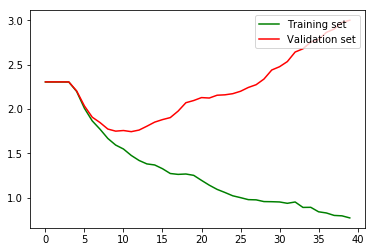

<Figure size 432x288 with 0 Axes>

In [134]:
visualize_costs(training_cost, validation_cost, display=True)

Overfitting with this setting, and it occurs very fast!

#### What happens if you use He initialization?

In [139]:
weights_he, biases_he = he_initialization_k_layers([[50, 3072], [30, 50], [10, 30]])

GD_params = [100, 0.0171384811847413, 10]

weights_he, biases_he, training_cost_he, validation_cost_he = MiniBatchGDwithMomentum(X_training_1,
                                                                          Y_training_1,
                                                                          X_training_2,
                                                                          Y_training_2,
                                                                          y_training_2,
                                                                          GD_params,
                                                                          weights_he, biases_he,
                                                                          regularization_term=0.0001)

for i in range(len(training_cost_he)):
    print(f'Cost of training with He initialization at epoch {i+1} is {training_cost_he[i]}')

100%|██████████| 10/10 [00:16<00:00,  1.66s/it]

Cost of training with He initialization at epoch 1 is 2.573371144365728
Cost of training with He initialization at epoch 2 is 2.4388440346442506
Cost of training with He initialization at epoch 3 is 2.3685662732480903
Cost of training with He initialization at epoch 4 is 2.3142257340862384
Cost of training with He initialization at epoch 5 is 2.272922477058916
Cost of training with He initialization at epoch 6 is 2.236912218216597
Cost of training with He initialization at epoch 7 is 2.2052890641621268
Cost of training with He initialization at epoch 8 is 2.1762496203378463
Cost of training with He initialization at epoch 9 is 2.1514607505444694
Cost of training with He initialization at epoch 10 is 2.1297865298452456


Although the loss does not remain stable, we don't observe much of a change. Again, we try for some more epochs and now plot the evolution:

In [140]:
weights_he, biases_he = he_initialization_k_layers([[50, 3072], [30, 50], [10, 30]])

GD_params = [100, 0.0171384811847413, 40]

weights_he, biases_he, training_cost_he, validation_cost_he = MiniBatchGDwithMomentum(X_training_1,
                                                                          Y_training_1,
                                                                          X_training_2,
                                                                          Y_training_2,
                                                                          y_training_2,
                                                                          GD_params,
                                                                          weights_he, biases_he,
                                                                          regularization_term=0.0001)



100%|██████████| 40/40 [01:06<00:00,  1.67s/it]


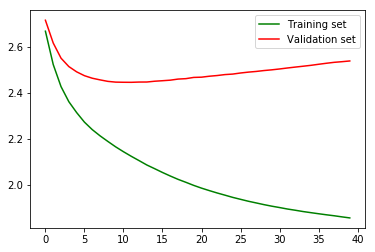

<Figure size 432x288 with 0 Axes>

In [141]:
visualize_costs(training_cost_he, validation_cost_he, display=True)

Smoother than earlier tries, but still overfitting after few epochs.

### EXERCISE 3: Implement batch normalization

#### Check your analytical gradients computation in comparison with the numerical ones for 2 layers and 50 hidden nodes

Compare for 2 layers:

In [120]:
weights, biases = initialize_weights([[50, 3072], [10, 50]])

p, batch_normalization_activations, batch_normalization_outputs, intermediate_outputs, means, variances = ForwardPassBatchNormalization(X_training_1[:, :4], weights, biases)
weights_2, biases_2 = BackwardPassBatchNormalization(X_training_1[:, :4], Y_training_1[:, :4], weights, biases, p, batch_normalization_outputs, batch_normalization_activations, intermediate_outputs, means, variances, regularization_term=0)

two_layers = np.load('2_layers.npz')

check_similarity(weights_2, biases_2, [two_layers['w0'], two_layers['w1'] ], [two_layers['b0'], two_layers['b1']])

-----------------
Layer no. 1:
Deviation on weight matrix: 1.2597928505427309e-08
Deviation on bias vector: 0.04489583333333333
-----------------
Layer no. 2:
Deviation on weight matrix: 1.061126355032502e-09
Deviation on bias vector: 1.085592909420537e-09


Compare for 3 layers:

In [121]:
weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])
w3_num, b3_num = ComputeGradsNumSlowBatchNorm(X_training_1[:, :2], Y_training_1[:, :2], weights, biases)


100%|██████████| 50/50 [22:48<00:00, 27.37s/it]

100%|██████████| 30/30 [00:12<00:00,  2.36it/s]

100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


In [122]:
np.savez('3_layers_num', w0=w3_num[0], w1=w3_num[1], w2=w3_num[2], b0=b3_num[0], b1=b3_num[1], b2=b3_num[2] )

In [124]:
weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

p, batch_normalization_activations, batch_normalization_outputs, intermediate_outputs, means, variances = ForwardPassBatchNormalization(X_training_1[:, :2], weights, biases)
weights_3, biases_3= BackwardPassBatchNormalization(X_training_1[:, :2], Y_training_1[:, :2], weights, biases, p, batch_normalization_outputs, batch_normalization_activations, intermediate_outputs, means, variances, regularization_term=0)

In [125]:
check_similarity(weights_3, biases_3, w3_num, b3_num)

-----------------
Layer no. 1:
Deviation on weight matrix: 1.4574774508711658e-05
Deviation on bias vector: 0.020078843569924645
-----------------
Layer no. 2:
Deviation on weight matrix: 0.0006714264687067433
Deviation on bias vector: 0.1015625
-----------------
Layer no. 3:
Deviation on weight matrix: 1.0708749294639795e-11
Deviation on bias vector: 1.2260625257832792e-11


Compare for 4 layers:

In [126]:
weights, biases = initialize_weights([[50, 3072], [20, 50], [15, 20], [10, 15]])

p, batch_normalization_activations, batch_normalization_outputs, intermediate_outputs, means, variances = ForwardPassBatchNormalization(X_training_1[:, :4], weights, biases)
weights_4, biases_4 = BackwardPassBatchNormalization(X_training_1[:, :4], Y_training_1[:, :4], weights, biases, p, batch_normalization_outputs, batch_normalization_activations, intermediate_outputs, means, variances, regularization_term=0)

four_layers = np.load('4_layers.npz')

check_similarity(weights_4, biases_4, [four_layers['w0'], four_layers['w1'], four_layers['w2'], four_layers['w3']], [four_layers['b0'], four_layers['b1'], four_layers['b2'], four_layers['b3']])

-----------------
Layer no. 1:
Deviation on weight matrix: 2.894663197138072e-09
Deviation on bias vector: 0.16003125
-----------------
Layer no. 2:
Deviation on weight matrix: 4.848126914126361e-10
Deviation on bias vector: 0.0738525390625
-----------------
Layer no. 3:
Deviation on weight matrix: 4.899817892918272e-10
Deviation on bias vector: 0.11653645833333333
-----------------
Layer no. 4:
Deviation on weight matrix: 9.78062348082e-10
Deviation on bias vector: 1.7724027351071386e-09


#### Overfiiting in a small subset of the training data

In [72]:
def sanity():

    weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])
    GD_params = [100, 0.05, 200]

    best_weights, best_biases, training_loss, validation_loss, exponentials = MiniBatchGDBatchNormalization(X_training_1[:, :1000], Y_training_1[:, :1000], X_training_2[:, :1000], Y_training_2[:, :1000], y_training_2[:1000], GD_params, weights, biases, regularization_term=1e-6)

    visualize_costs(training_loss, validation_loss, display=True, title='Overfitting at a small dataset')
    print(f'Training set accuracy: {ComputeAccuracyBatchNormalization(X_training_1[:, :100], y_training_1[:100], best_weights, best_biases)}')
    print(f'Validation set accuracy: {ComputeAccuracyBatchNormalization(X_training_2[:, :100], y_training_2[:100], best_weights, best_biases)}')


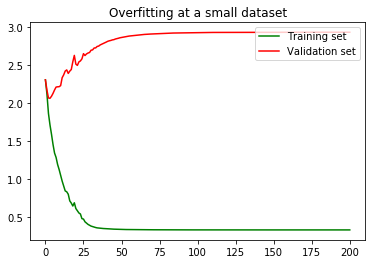

Training set accuracy: 100.0
Validation set accuracy: 34.0


<Figure size 432x288 with 0 Axes>

In [75]:
sanity()

#### Random search for good ranges of $\eta$

In [76]:
def random_search():

    for eta in [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]:
        print('-----------------------')
        print('eta: ', eta)

        GD_params = [100, eta, 5]

        weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

        best_weights, best_biases, cost, val_cost, exponentials = MiniBatchGDBatchNormalization( X_training_1,
                                                                                                 Y_training_1,
                                                                                                 X_training_2,
                                                                                                 Y_training_2,
                                                                                                 y_training_2,
                                                                                                 GD_params,
                                                                                                 weights,
                                                                                                 biases,
                                                                                                 regularization_term=1e-6)

        print()
        for epoch, loss in enumerate(cost):
            print(f'Cross-entropy loss at epoch no.{epoch+1}: {loss}')
        print()



        print(f'Validation set accuracy: {ComputeAccuracyBatchNormalization(X_training_2, y_training_2, best_weights, best_biases, exponentials)}%')

    for eta in np.arange(0.15, 1.05, 0.05):

        print('-----------------------')
        print('eta: ', eta)

        GD_params = [100, eta, 5]

        weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

        best_weights, best_biases, cost, val_cost, exponentials = MiniBatchGDBatchNormalization(    X_training_1,
                                                                                                    Y_training_1,
                                                                                                    X_training_2,
                                                                                                    Y_training_2,
                                                                                                    y_training_2,
                                                                                                    GD_params,
                                                                                                    weights,
                                                                                                    biases,
                                                                                                    regularization_term=0.000001)
        print()
        for epoch, loss in enumerate(cost):
            print(f'Cross-entropy loss at epoch no.{epoch+1}: {loss}')
        print()

        print(f'Validation set accuracy: {ComputeAccuracyBatchNormalization(X_training_2, y_training_2, best_weights, best_biases, exponentials)}%')



In [77]:
random_search()

-----------------------
eta:  1e-05

Cross-entropy loss at epoch no.1: 2.3024004969856926
Cross-entropy loss at epoch no.2: 2.30141070312675
Cross-entropy loss at epoch no.3: 2.3003529146639976
Cross-entropy loss at epoch no.4: 2.299162285333397
Cross-entropy loss at epoch no.5: 2.2978090525437764
Cross-entropy loss at epoch no.6: 2.2963016696759535

Validation set accuracy: 24.55%
-----------------------
eta:  5e-05

Cross-entropy loss at epoch no.1: 2.3023449026664626
Cross-entropy loss at epoch no.2: 2.2962484257373554
Cross-entropy loss at epoch no.3: 2.2837450514713153
Cross-entropy loss at epoch no.4: 2.267923037061595
Cross-entropy loss at epoch no.5: 2.2515390217750118
Cross-entropy loss at epoch no.6: 2.2351971685492837

Validation set accuracy: 26.49%
-----------------------
eta:  0.0001

Cross-entropy loss at epoch no.1: 2.3024923089332536
Cross-entropy loss at epoch no.2: 2.287360237749634
Cross-entropy loss at epoch no.3: 2.2534343154472865
Cross-entropy loss at epoch no.4


Cross-entropy loss at epoch no.1: 2.302718603574153
Cross-entropy loss at epoch no.2: 1.8421188610053985
Cross-entropy loss at epoch no.3: 1.8730222913914507
Cross-entropy loss at epoch no.4: 1.771837393063317
Cross-entropy loss at epoch no.5: 1.7143272634204816
Cross-entropy loss at epoch no.6: 1.6310248843778243

Validation set accuracy: 35.7%
-----------------------
eta:  0.8000000000000003

Cross-entropy loss at epoch no.1: 2.30242225407954
Cross-entropy loss at epoch no.2: 1.8992315621545701
Cross-entropy loss at epoch no.3: 1.7852927313772806
Cross-entropy loss at epoch no.4: 1.7586761820883994
Cross-entropy loss at epoch no.5: 1.7088413294724207
Cross-entropy loss at epoch no.6: 1.6704572146728551

Validation set accuracy: 35.05%
-----------------------
eta:  0.8500000000000002

Cross-entropy loss at epoch no.1: 2.3029103929135735
Cross-entropy loss at epoch no.2: 1.8969333111551514
Cross-entropy loss at epoch no.3: 1.8883063460307858
Cross-entropy loss at epoch no.4: 1.8387276

#### Coarse-to-Fine search

After performing a random search on values for $\eta$ with no regularization, the intervals between [0.01, 0.1] and [0.6, 1] were selected for a more thorough investigation

In [86]:
def coarse_search():
    """
    First step of coarse search, where good values for eta derived from random_search are tested along
    with many tries for the amount of regularization.

    :return: None
    """

    accuracies = []
    etas = []
    lambdas = []

    for regularization_term in [1e-6, 1e-5, 1e-4, 1e-3]:

        e_min = np.log(0.005)
        e_max = np.log(0.15)

        for _ in range(50):

            eta_term = np.random.rand(1, 1).flatten()[0]
            e = e_min + (e_max - e_min) * eta_term
            eta = np.exp(e)
            etas.append(eta)

            lambdas.append(regularization_term)

            GD_params = [100, eta, 10]

            weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

            best_weights, best_biases, cost, val_cost, exponentials = MiniBatchGDBatchNormalization(
                X_training_1,
                Y_training_1,
                X_training_2,
                Y_training_2,
                y_training_2,
                GD_params,
                weights,
                biases,
                regularization_term,
                False)
            
            print('---------------------------------')
            print('Learning rate: ' + str(eta) + ', amount of regularization term: ' + str(regularization_term))
            accuracy_on_validation_set = ComputeAccuracyBatchNormalization(X_training_2, y_training_2, best_weights, best_biases, exponentials)
            accuracies.append(accuracy_on_validation_set)
            print('Accuracy performance on the validation set: ', accuracy_on_validation_set)

    sort_them_all = sorted(zip(accuracies, etas, lambdas))

    best_accuracies = [x for x, _, _ in sort_them_all]
    best_etas = [y for _, y, _ in sort_them_all]
    best_lambdas = [z for _, _, z in sort_them_all]

    print('---------------------------------')
    print('BEST PERFORMANCE: ', str(best_accuracies[-1]))
    print('Best eta: ', best_etas[-1])
    print('Best lambda: ', best_lambdas[-1])

    print('---------------------------------')
    print('SECOND BEST PERFORMANCE: ', str(best_accuracies[-2]))
    print('Second best eta: ', best_etas[-2])
    print('Second best lambda: ', best_lambdas[-2])

    print('---------------------------------')
    print('THIRD BEST PERFORMANCE: ', str(best_accuracies[-3]))
    print('Third best eta: ', best_etas[-3])
    print('Third best lambda: ', best_lambdas[-3])

In [87]:
coarse_search()

---------------------------------
Learning rate: 0.04578466336957471, amount of regularization term: 1e-06
Accuracy performance on the validation set:  40.79
---------------------------------
Learning rate: 0.11920790455976901, amount of regularization term: 1e-06
Accuracy performance on the validation set:  40.45
---------------------------------
Learning rate: 0.031558683059269926, amount of regularization term: 1e-06
Accuracy performance on the validation set:  41.22
---------------------------------
Learning rate: 0.13843571173329083, amount of regularization term: 1e-06
Accuracy performance on the validation set:  39.33
---------------------------------
Learning rate: 0.05308802864211276, amount of regularization term: 1e-06
Accuracy performance on the validation set:  39.05
---------------------------------
Learning rate: 0.012518634645423575, amount of regularization term: 1e-06
Accuracy performance on the validation set:  40.78
---------------------------------
Learning rate: 0

---------------------------------
Learning rate: 0.10879332627717456, amount of regularization term: 1e-05
Accuracy performance on the validation set:  40.33
---------------------------------
Learning rate: 0.058387892860951536, amount of regularization term: 1e-05
Accuracy performance on the validation set:  40.16
---------------------------------
Learning rate: 0.01170735533235222, amount of regularization term: 1e-05
Accuracy performance on the validation set:  40.78
---------------------------------
Learning rate: 0.02566745907043904, amount of regularization term: 1e-05
Accuracy performance on the validation set:  40.55
---------------------------------
Learning rate: 0.02745729071403371, amount of regularization term: 1e-05
Accuracy performance on the validation set:  41.12
---------------------------------
Learning rate: 0.00755395671949037, amount of regularization term: 1e-05
Accuracy performance on the validation set:  41.71
---------------------------------
Learning rate: 0.

---------------------------------
Learning rate: 0.05038170433374072, amount of regularization term: 0.0001
Accuracy performance on the validation set:  40.42
---------------------------------
Learning rate: 0.005078669888458132, amount of regularization term: 0.0001
Accuracy performance on the validation set:  40.71
---------------------------------
Learning rate: 0.016339866276654423, amount of regularization term: 0.0001
Accuracy performance on the validation set:  40.88
---------------------------------
Learning rate: 0.10027525930005092, amount of regularization term: 0.0001
Accuracy performance on the validation set:  40.67
---------------------------------
Learning rate: 0.09982040292425287, amount of regularization term: 0.0001
Accuracy performance on the validation set:  39.01
---------------------------------
Learning rate: 0.020193135410301696, amount of regularization term: 0.0001
Accuracy performance on the validation set:  41.95
---------------------------------
Learning 

---------------------------------
Learning rate: 0.1295029258729205, amount of regularization term: 0.001
Accuracy performance on the validation set:  39.07
---------------------------------
Learning rate: 0.005697896537461265, amount of regularization term: 0.001
Accuracy performance on the validation set:  40.92
---------------------------------
Learning rate: 0.0052412107050517414, amount of regularization term: 0.001
Accuracy performance on the validation set:  41.08
---------------------------------
Learning rate: 0.016238179952563346, amount of regularization term: 0.001
Accuracy performance on the validation set:  38.81
---------------------------------
Learning rate: 0.07945997562325698, amount of regularization term: 0.001
Accuracy performance on the validation set:  39.95
---------------------------------
Learning rate: 0.05800803416280395, amount of regularization term: 0.001
Accuracy performance on the validation set:  41.84
---------------------------------
Learning rate: 

A few observations that can be made for each regularization setting:

i) For $\lambda$ = $10^{-6}$ accuracy exceed 42% for $\eta$ in [0.027, 0.06]  
ii) For $\lambda$ = $10^{-5}$ accuracy reaches high valued for $\eta$'s close to 0.01 and 0.065, and no similar tests were ran, so we can test this direction too  
iii) For $\lambda$ = $10^{-4}$ the best space to search for good values is [0.01, 0.02]  
iv) For a value of $\lambda$ as high as $10^{-3}$ we can find good validation set accuracy performance in both close to 0.01 and 0.1 for $\eta$  

#### Fine search

In [88]:
def fine_search():
    """
    Fine search based on the results of coarse search

    """

    accuracies = []
    etas = []
    lambdas = []

    # Lambda = 10^(-6)
    regularization_term = 1e-6

    e_min = np.log(0.027)
    e_max = np.log(0.06)

    for _ in range(20):
        eta_term = np.random.rand(1, 1).flatten()[0]
        e = e_min + (e_max - e_min) * eta_term
        eta = np.exp(e)
        etas.append(eta)

        lambdas.append(regularization_term)

        GD_params = [100, eta, 10]

        weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

        best_weights, best_biases, cost, val_cost, exponentials = MiniBatchGDBatchNormalization(
            X_training_1,
            Y_training_1,
            X_training_2,
            Y_training_2,
            y_training_2,
            GD_params,
            weights,
            biases,
            regularization_term)

        print('---------------------------------')
        print('Learning rate: ' + str(eta) + ', amount of regularization term: ' + str(regularization_term))
        accuracy_on_validation_set = ComputeAccuracyBatchNormalization(X_training_2, y_training_2, best_weights,
                                                                       best_biases,
                                                                       exponentials)
        accuracies.append(accuracy_on_validation_set)
        print('Accuracy performance on the validation set: ', accuracy_on_validation_set)

    # Lambda = 10^(-5)
    regularization_term = 1e-5

    e_min = np.log(0.005)
    e_max = np.log(0.015)

    for _ in range(20):
        eta_term = np.random.rand(1, 1).flatten()[0]
        e = e_min + (e_max - e_min) * eta_term
        eta = np.exp(e)
        etas.append(eta)

        lambdas.append(regularization_term)

        GD_params = [100, eta, 10]

        weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

        best_weights, best_biases, cost, val_cost, exponentials = MiniBatchGDBatchNormalization(
            X_training_1,
            Y_training_1,
            X_training_2,
            Y_training_2,
            y_training_2,
            GD_params,
            weights,
            biases,
            regularization_term)

        print('---------------------------------')
        print('Learning rate: ' + str(eta) + ', amount of regularization term: ' + str(regularization_term))
        accuracy_on_validation_set = ComputeAccuracyBatchNormalization(X_training_2, y_training_2, best_weights,
                                                                       best_biases,
                                                                       exponentials)
        accuracies.append(accuracy_on_validation_set)
        print('Accuracy performance on the validation set: ', accuracy_on_validation_set)

    e_min = np.log(0.06)
    e_max = np.log(0.07)

    for _ in range(20):
        eta_term = np.random.rand(1, 1).flatten()[0]
        e = e_min + (e_max - e_min) * eta_term
        eta = np.exp(e)
        etas.append(eta)

        lambdas.append(regularization_term)

        GD_params = [100, eta, 10]

        weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

        best_weights, best_biases, cost, val_cost, exponentials = MiniBatchGDBatchNormalization(
            X_training_1,
            Y_training_1,
            X_training_2,
            Y_training_2,
            y_training_2,
            GD_params,
            weights,
            biases,
            regularization_term)

        print('---------------------------------')
        print('Learning rate: ' + str(eta) + ', amount of regularization term: ' + str(regularization_term))
        accuracy_on_validation_set = ComputeAccuracyBatchNormalization(X_training_2, y_training_2, best_weights,
                                                                       best_biases,
                                                                       exponentials)
        accuracies.append(accuracy_on_validation_set)
        print('Accuracy performance on the validation set: ', accuracy_on_validation_set)

    # Lambda = 10^(-4)
    regularization_term = 1e-4

    e_min = np.log(0.01)
    e_max = np.log(0.02)

    for _ in range(10):
        eta_term = np.random.rand(1, 1).flatten()[0]
        e = e_min + (e_max - e_min) * eta_term
        eta = np.exp(e)
        etas.append(eta)

        lambdas.append(regularization_term)

        GD_params = [100, eta, 10]

        weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

        best_weights, best_biases, cost, val_cost, exponentials = MiniBatchGDBatchNormalization(
            X_training_1,
            Y_training_1,
            X_training_2,
            Y_training_2,
            y_training_2,
            GD_params,
            weights,
            biases,
            regularization_term)

        print('---------------------------------')
        print('Learning rate: ' + str(eta) + ', amount of regularization term: ' + str(regularization_term))
        accuracy_on_validation_set = ComputeAccuracyBatchNormalization(X_training_2, y_training_2, best_weights,
                                                                       best_biases,
                                                                       exponentials)
        accuracies.append(accuracy_on_validation_set)
        print('Accuracy performance on the validation set: ', accuracy_on_validation_set)

    # Lambda = 10^(-3)
    regularization_term = 1e-3

    e_min = np.log(0.005)
    e_max = np.log(0.015)

    for _ in range(10):
        eta_term = np.random.rand(1, 1).flatten()[0]
        e = e_min + (e_max - e_min) * eta_term
        eta = np.exp(e)
        etas.append(eta)

        lambdas.append(regularization_term)

        GD_params = [100, eta, 10]

        weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

        best_weights, best_biases, cost, val_cost, exponentials = MiniBatchGDBatchNormalization(
            X_training_1,
            Y_training_1,
            X_training_2,
            Y_training_2,
            y_training_2,
            GD_params,
            weights,
            biases,
            regularization_term)

        print('---------------------------------')
        print('Learning rate: ' + str(eta) + ', amount of regularization term: ' + str(regularization_term))
        accuracy_on_validation_set = ComputeAccuracyBatchNormalization(X_training_2, y_training_2, best_weights,
                                                                       best_biases,
                                                                       exponentials)
        accuracies.append(accuracy_on_validation_set)
        print('Accuracy performance on the validation set: ', accuracy_on_validation_set)

    e_min = np.log(0.09)
    e_max = np.log(0.11)

    for _ in range(10):
        eta_term = np.random.rand(1, 1).flatten()[0]
        e = e_min + (e_max - e_min) * eta_term
        eta = np.exp(e)
        etas.append(eta)

        lambdas.append(regularization_term)

        GD_params = [100, eta, 10]

        weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

        best_weights, best_biases, cost, val_cost, exponentials, exponential_variances = MiniBatchGDBatchNormalization(
            X_training_1,
            Y_training_1,
            X_training_2,
            Y_training_2,
            y_training_2,
            GD_params,
            weights,
            biases,
            regularization_term)

        print('---------------------------------')
        print('Learning rate: ' + str(eta) + ', amount of regularization term: ' + str(regularization_term))
        accuracy_on_validation_set = ComputeAccuracyBatchNormalization(X_training_2, y_training_2, best_weights,
                                                                       best_biases,
                                                                       exponentials)
        accuracies.append(accuracy_on_validation_set)
        print('Accuracy performance on the validation set: ', accuracy_on_validation_set)

    sort_them_all = sorted(zip(accuracies, etas, lambdas))

    best_accuracies = [x for x, _, _ in sort_them_all]
    best_etas = [y for _, y, _ in sort_them_all]
    best_lambdas = [z for _, _, z in sort_them_all]

    print('---------------------------------')
    print('BEST PERFORMANCE: ', str(best_accuracies[-1]))
    print('Best eta: ', best_etas[-1])
    print('Best lambda: ', best_lambdas[-1])

    print('---------------------------------')
    print('SECOND BEST PERFORMANCE: ', str(best_accuracies[-2]))
    print('Second best eta: ', best_etas[-2])
    print('Second best lambda: ', best_lambdas[-2])

    print('---------------------------------')
    print('THIRD BEST PERFORMANCE: ', str(best_accuracies[-3]))
    print('Third best eta: ', best_etas[-3])
    print('Third best lambda: ', best_lambdas[-3])

In [89]:
fine_search()

---------------------------------
Learning rate: 0.02905109667305325, amount of regularization term: 1e-06
Accuracy performance on the validation set:  40.78
---------------------------------
Learning rate: 0.030459438029090218, amount of regularization term: 1e-06
Accuracy performance on the validation set:  41.23
---------------------------------
Learning rate: 0.05358893887759502, amount of regularization term: 1e-06
Accuracy performance on the validation set:  40.77
---------------------------------
Learning rate: 0.045296741753274035, amount of regularization term: 1e-06
Accuracy performance on the validation set:  40.04
---------------------------------
Learning rate: 0.035532596573735024, amount of regularization term: 1e-06
Accuracy performance on the validation set:  40.98
---------------------------------
Learning rate: 0.03666996262672731, amount of regularization term: 1e-06
Accuracy performance on the validation set:  40.11
---------------------------------
Learning rate: 

---------------------------------
Learning rate: 0.06575783995307094, amount of regularization term: 1e-05
Accuracy performance on the validation set:  41.14
---------------------------------
Learning rate: 0.06922001552108539, amount of regularization term: 1e-05
Accuracy performance on the validation set:  40.39
---------------------------------
Learning rate: 0.06271246993639171, amount of regularization term: 1e-05
Accuracy performance on the validation set:  40.22
---------------------------------
Learning rate: 0.06514258680934436, amount of regularization term: 1e-05
Accuracy performance on the validation set:  40.92
---------------------------------
Learning rate: 0.06837906428004828, amount of regularization term: 1e-05
Accuracy performance on the validation set:  40.82
---------------------------------
Learning rate: 0.06314887808555977, amount of regularization term: 1e-05
Accuracy performance on the validation set:  40.1
---------------------------------
Learning rate: 0.06

ValueError: not enough values to unpack (expected 6, got 5)